In [1]:
import avstack
import avapi

data_dir = '../examples/sim-results/'
CSM = avapi.carla.CarlaScenesManager(data_dir=data_dir)

Cannot import rss library -- don't worry about this unless you need 'safety' evals
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
CSM.scenes

['run_2023_09_06_15:27:48']

In [3]:
CDM = CSM.get_scene_dataset_by_index(0)

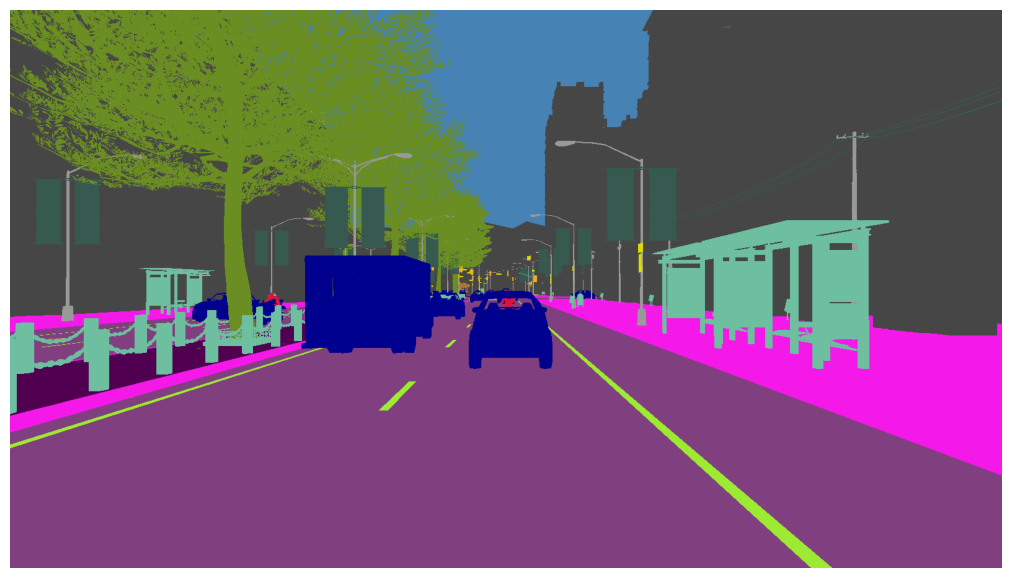

In [4]:
frame = CDM.frames[-10]
rad = CDM.get_radar(frame=frame)
ssimg = CDM.get_semseg_image(frame=frame)
ssimg.view()

In [40]:
import numpy as np

In [51]:
rad = CDM.get_radar(frame=frame, sensor="main_radar")
np.mean(rad.data.x, axis=0)

array([-1.9115617e+00, -2.7371246e-02, -2.3383375e-02,  2.5041800e+01],
      dtype=float32)

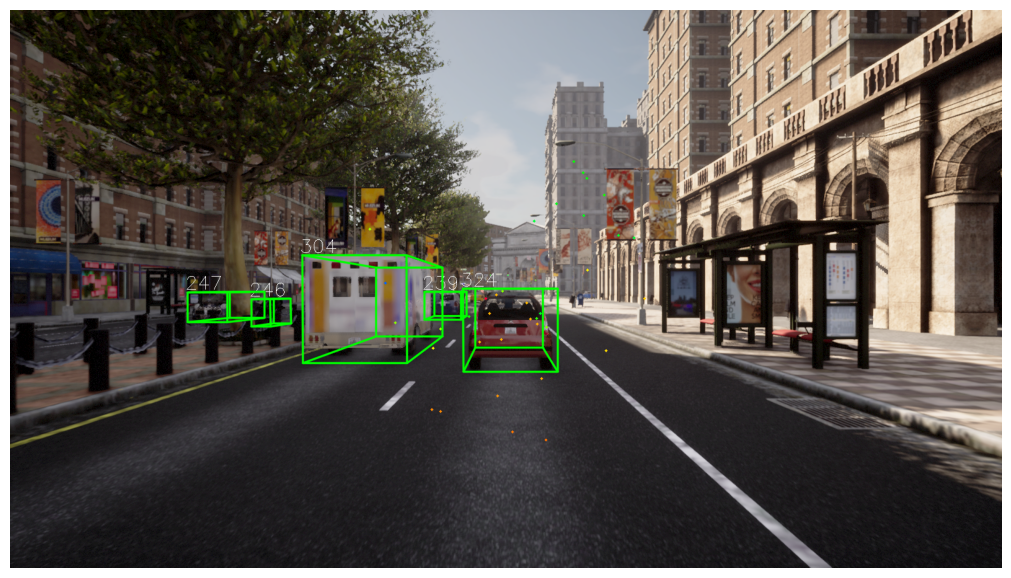

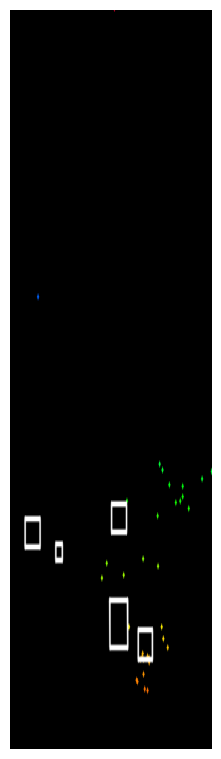

In [65]:
img = CDM.get_image(frame=frame, sensor="main_camera")
pc = CDM.get_lidar(frame=frame, sensor="main_lidar")
rad = CDM.get_radar(frame=frame, sensor="main_radar")
objs = CDM.get_objects(frame=frame, sensor="main_radar", max_occ=avstack.environment.objects.Occlusion.PARTIAL)
rad.data.x = rad.data.x[:,[3,1,2,0]]
rad_c = rad.convert_to_cartesian()

avapi.visualize.snapshot.show_lidar_on_image(rad_c, img, boxes=objs)
avapi.visualize.snapshot.show_lidar_bev_with_boxes(rad_c, boxes=objs)